In [1]:
# Allow the PyMC3 models to be imported in the notebook folder

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from pymc3 import summary, traceplot
import pymc3 as pm

import theano
import theano.tensor as T

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

In [4]:
from pymc3_models.models.HierarchicalLogisticRegression import HierarchicalLogisticRegression

In [5]:
num_pred = 2
num_samples = 700000
num_categories = 2

In [6]:
alphas = 5 * np.random.randn(num_categories) + 5 # mu_alpha = sigma_alpha = 5
betas = 10 * np.random.randn(num_categories, num_pred) + 10 # mu_beta = sigma_beta = 10

In [7]:
alphas

array([ 2.49795629,  2.34058013])

In [8]:
betas

array([[  4.73162177,  23.25989698],
       [ -6.83849536,   6.35186135]])

In [9]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [10]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

X = np.concatenate([x_a, x_b])
Y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

Fit w/ ADVI
===

In [11]:
HLM1 = HierarchicalLogisticRegression()

In [12]:
HLM1.fit(X, Y, cats, minibatch_size=2000, inference_args={'n': 350000})

Average Loss = 222.78: 100%|██████████| 350000/350000 [12:32<00:00, 465.03it/s]
Finished [100%]: Average Loss = 222.81


HierarchicalLogisticRegression()

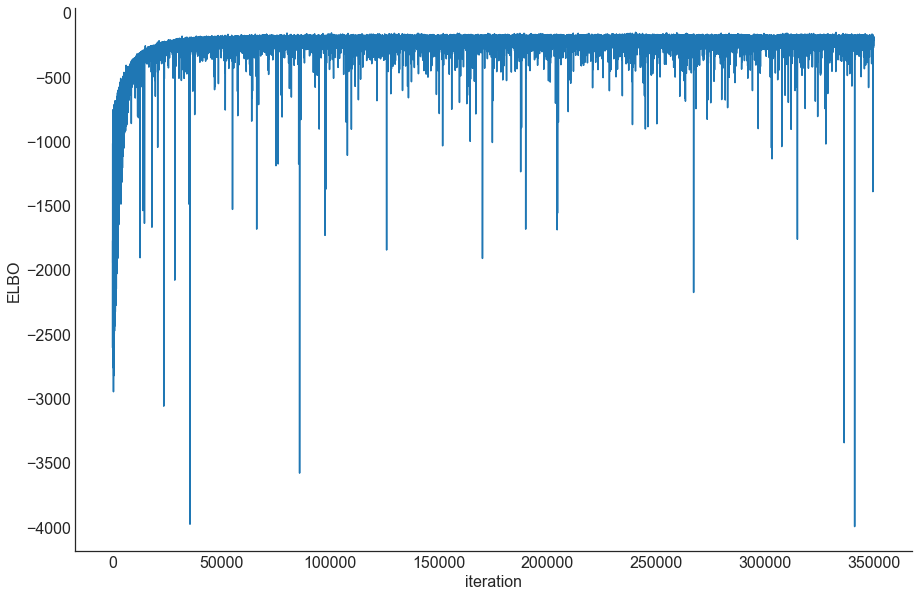

In [13]:
HLM1.plot_elbo()

In [14]:
summary(HLM1.trace[1000:])


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.432            2.562            0.026            [-2.801, 7.308]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.669         0.701          2.417          4.154          7.452


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  6.847            8.251            0.097            [-9.524, 22.734]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -9.261         1.161          6.836          12.485         23.014


alpha:

  Mean             SD               MC Error         95% HPD interval
  ----------------

In [15]:
alphas

array([ 2.49795629,  2.34058013])

In [16]:
betas

array([[  4.73162177,  23.25989698],
       [ -6.83849536,   6.35186135]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13dfdf7f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13d210358>]], dtype=object)

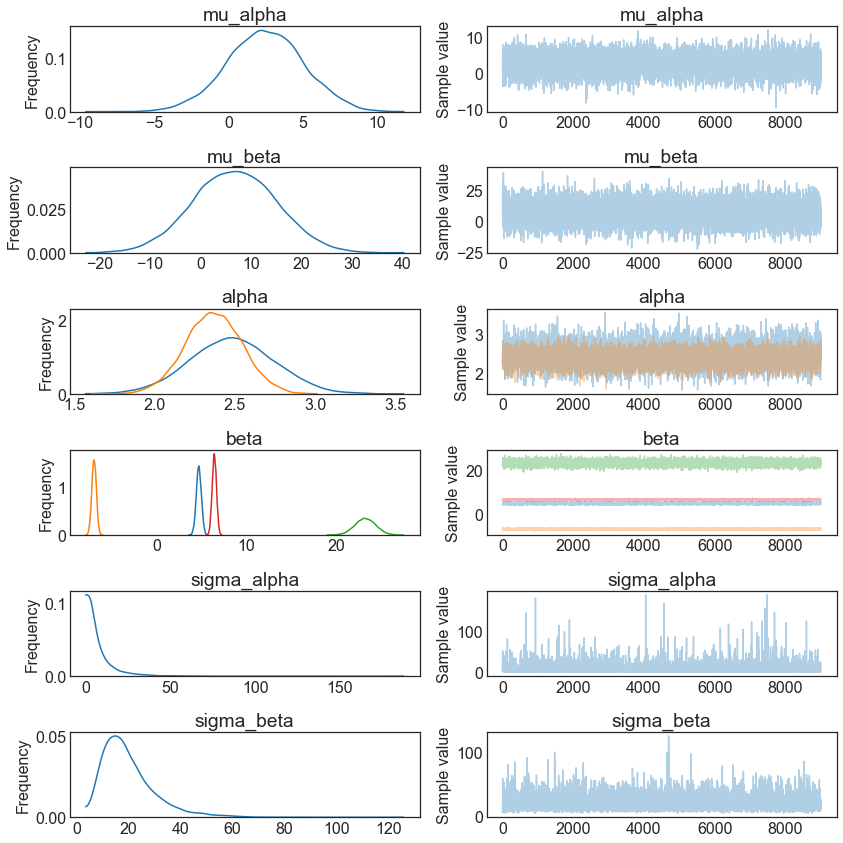

In [17]:
traceplot(HLM1.trace[1000:])

In [18]:
#probs = HLM1.predict_proba(X, cats)

In [19]:
#pred = HLM1.predict(X, cats)

In [20]:
HLM1.score(X, Y, cats)

100%|██████████| 2000/2000 [05:23<00:00,  6.19it/s]


0.96031571428571427

In [21]:
HLM1.save('pickle_jar/HLR_jar/')

In [22]:
HLM1.num_cats

2

In [23]:
HLM2 = HierarchicalLogisticRegression()

In [24]:
HLM2.load('pickle_jar/HLR_jar/')

In [25]:
HLM2.score(X, Y, cats)

100%|██████████| 2000/2000 [05:24<00:00,  6.16it/s]


0.96030357142857148

Fit w/ NUTS
===

In [26]:
HLM3 = HierarchicalLogisticRegression()

In [27]:
HLM3.fit(X, Y, cats, inference_type='nuts', inference_args={'draws': 2000})

100%|██████████| 2500/2500 [17:56:57<00:00, 25.85s/it]   /Users/ncarlson/repos/personal/pymc3_models/venv/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 869 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



HierarchicalLogisticRegression()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c7c3fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13c994b38>]], dtype=object)

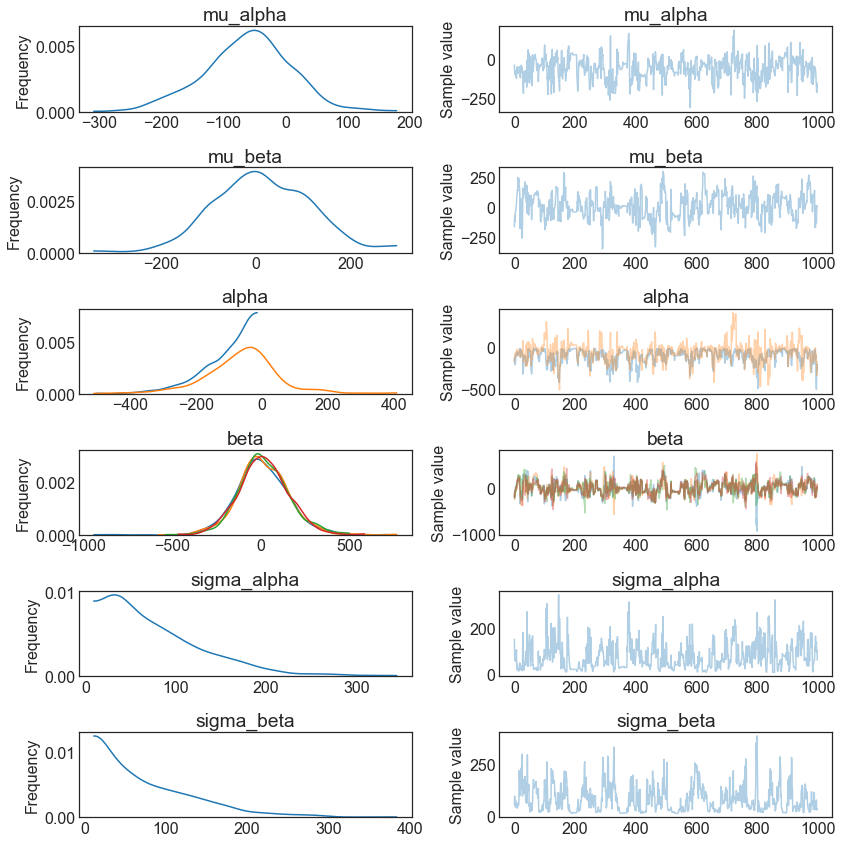

In [29]:
traceplot(HLM3.trace[1000:])

In [30]:
HLM3.score(X, Y, cats)

100%|██████████| 2000/2000 [04:04<00:00,  8.18it/s]


0.43066428571428572